# Economic Performance


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Sources


https://www.kaggle.com/datasets/johnbailey123hd/us-economic-indicators-1980-2023

https://www.kaggle.com/datasets/ogbuzurukelechi/economy-of-the-united-states-by-presidents

https://www.kaggle.com/datasets/georgescutelnicu/us-presidents


## Datasets


In [46]:
economic_growth_df = pd.read_csv("./datasets/USA Economy Growth.csv")
economic_indicators_df = pd.read_csv("./datasets/US_Economic_Indicators.csv")
presidents_df = pd.read_csv("./datasets/presidents.csv")

In [59]:
economic_growth_df

,Year,GDP,GDP per capita (in US$ PPP),GDP (in Bil. US$nominal),GDP per capita (in US$ nominal),GDP growth %,Inflation rate %,Unemployment %,Government debt (in% of GDP),Presidents
Presidents,,,,,,,,,,
Ronald Reagan,1981,3207.0,13948.7,3207.0,13948.7,2.50%,10.40%,7.60%,31.00%,Ronald Reagan
Ronald Reagan,1982,3343.8,14405.0,3343.8,14405.0,-1.80%,6.20%,9.70%,34.00%,Ronald Reagan
Ronald Reagan,1983,3634.0,15513.7,3634.0,15513.7,4.60%,3.20%,9.60%,37.00%,Ronald Reagan
Ronald Reagan,1984,4037.7,17086.4,4037.7,17086.4,7.20%,4.40%,7.50%,38.00%,Ronald Reagan
Ronald Reagan,1985,4339.0,18199.3,4339.0,18199.3,4.20%,3.50%,7.20%,41.00%,Ronald Reagan
Ronald Reagan,1986,4579.6,19034.8,4579.6,19034.8,3.50%,1.90%,7.00%,46.00%,Ronald Reagan
Ronald Reagan,1987,4855.3,20001.0,4855.3,20001.0,3.50%,3.60%,6.20%,48.00%,Ronald Reagan
Ronald Reagan,1988,5236.4,21376.0,5236.4,21376.0,4.20%,4.10%,5.50%,50.00%,Ronald Reagan
George H. W. Bush,1989,5641.6,22814.1,5641.6,22814.1,3.70%,4.80%,5.30%,51.00%,George H. W. Bush


## Analysis


In [47]:
economic_growth_df.head(n=5)

,Year,GDP,GDP per capita (in US$ PPP),GDP (in Bil. US$nominal),GDP per capita (in US$ nominal),GDP growth %,Inflation rate %,Unemployment %,Government debt (in% of GDP),Presidents
0,1981,3207.0,13948.7,3207.0,13948.7,2.50%,10.40%,7.60%,31.00%,Ronald Reagan
1,1982,3343.8,14405.0,3343.8,14405.0,-1.80%,6.20%,9.70%,34.00%,Ronald Reagan
2,1983,3634.0,15513.7,3634.0,15513.7,4.60%,3.20%,9.60%,37.00%,Ronald Reagan
3,1984,4037.7,17086.4,4037.7,17086.4,7.20%,4.40%,7.50%,38.00%,Ronald Reagan
4,1985,4339.0,18199.3,4339.0,18199.3,4.20%,3.50%,7.20%,41.00%,Ronald Reagan


In [48]:
presidential_parties_df = presidents_df[["Name", "Party"]]
presidential_parties_df.set_index(["Name"], drop=False, inplace=True)

In [49]:
economic_growth_df["Presidents"] = economic_growth_df["Presidents"].str.replace(
    "George Bush", "George H. W. Bush"
)
economic_growth_df.set_index(["Presidents"], drop=False, inplace=True)

In [50]:
presidential_performance_df = presidential_parties_df.join(economic_growth_df).dropna()
presidential_performance_df.drop(columns=["Presidents"], inplace=True)
presidential_performance_df.rename(
    columns={
        "Name": "name",
        "Party": "party",
        "Year": "year",
        "GDP ": "gdp",
        "GDP per capita (in US$ PPP)": "gdp_per_capita_ppp",
        "GDP (in Bil. US$nominal)": "gdp_per_billion",
        "GDP per capita (in US$ nominal)": "gdp_per_capita_nominal",
        "GDP growth %": "gdp_growth_percent",
        "Inflation rate %": "inflation_rate_percent",
        "Unemployment %": "unemployment_percent",
        "Government debt (in% of GDP)": "government_debt_by_percent_of_gdp",
    },
    inplace=True,
)
presidential_performance_df["year"] = presidential_performance_df["year"].astype(int)
presidential_performance_df["gdp"] = presidential_performance_df["gdp"].astype(float)


# Replace percentage strings with numeric values for inflation, unemployment, and debt
presidential_performance_df["inflation_rate_percent"] = (
    presidential_performance_df["inflation_rate_percent"].str.rstrip("%").astype(float)
)
presidential_performance_df["unemployment_percent"] = (
    presidential_performance_df["unemployment_percent"].str.rstrip("%").astype(float)
)
presidential_performance_df["government_debt_by_percent_of_gdp"] = (
    presidential_performance_df["government_debt_by_percent_of_gdp"]
    .str.rstrip("%")
    .astype(float)
)

# Create a new column that combines the year and president's name for x-axis labeling
presidential_performance_df["year_president"] = (
    presidential_performance_df["year"].astype(str)
    + "\n"
    + presidential_performance_df["name"]
)

presidential_performance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, Ronald Reagan to Joe Biden
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               43 non-null     object 
 1   party                              43 non-null     object 
 2   year                               43 non-null     int64  
 3   gdp                                43 non-null     float64
 4   gdp_per_capita_ppp                 43 non-null     float64
 5   gdp_per_billion                    43 non-null     float64
 6   gdp_per_capita_nominal             43 non-null     float64
 7   gdp_growth_percent                 43 non-null     object 
 8   inflation_rate_percent             43 non-null     float64
 9   unemployment_percent               43 non-null     float64
 10  government_debt_by_percent_of_gdp  43 non-null     float64
 11  year_president                     43 non-null

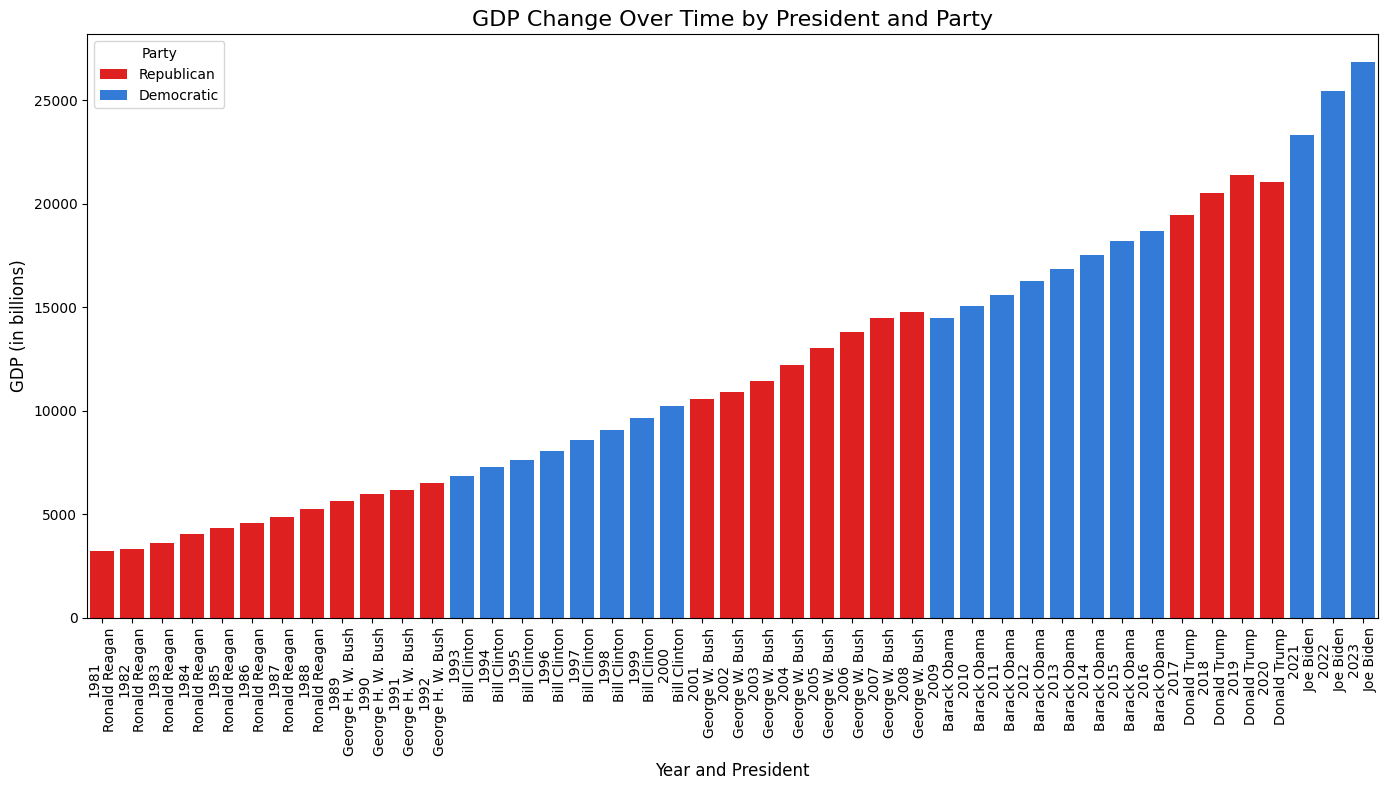

In [51]:
# Define a custom color palette for the parties
party_colors = {
    "Democratic": "#1877F2",  # Democratic Blue
    "Republican": "#FF0000",  # Republican Red
}


# Create a new column that combines the year and president's name
presidential_performance_df["year_president"] = (
    presidential_performance_df["year"].astype(str)
    + "\n"
    + presidential_performance_df["name"]
)

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the plot with a custom palette for party colors
sns.barplot(
    x="year_president",
    y="gdp",
    hue="party",
    data=presidential_performance_df,
    palette=party_colors,
    dodge=False,
)

# Set axis labels and title
plt.title("GDP Change Over Time by President and Party", fontsize=16)
plt.xlabel("Year and President", fontsize=12)
plt.ylabel("GDP (in billions)", fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="center")

# Add legend for party
plt.legend(title="Party")

# Display the plot
plt.tight_layout()
plt.show()

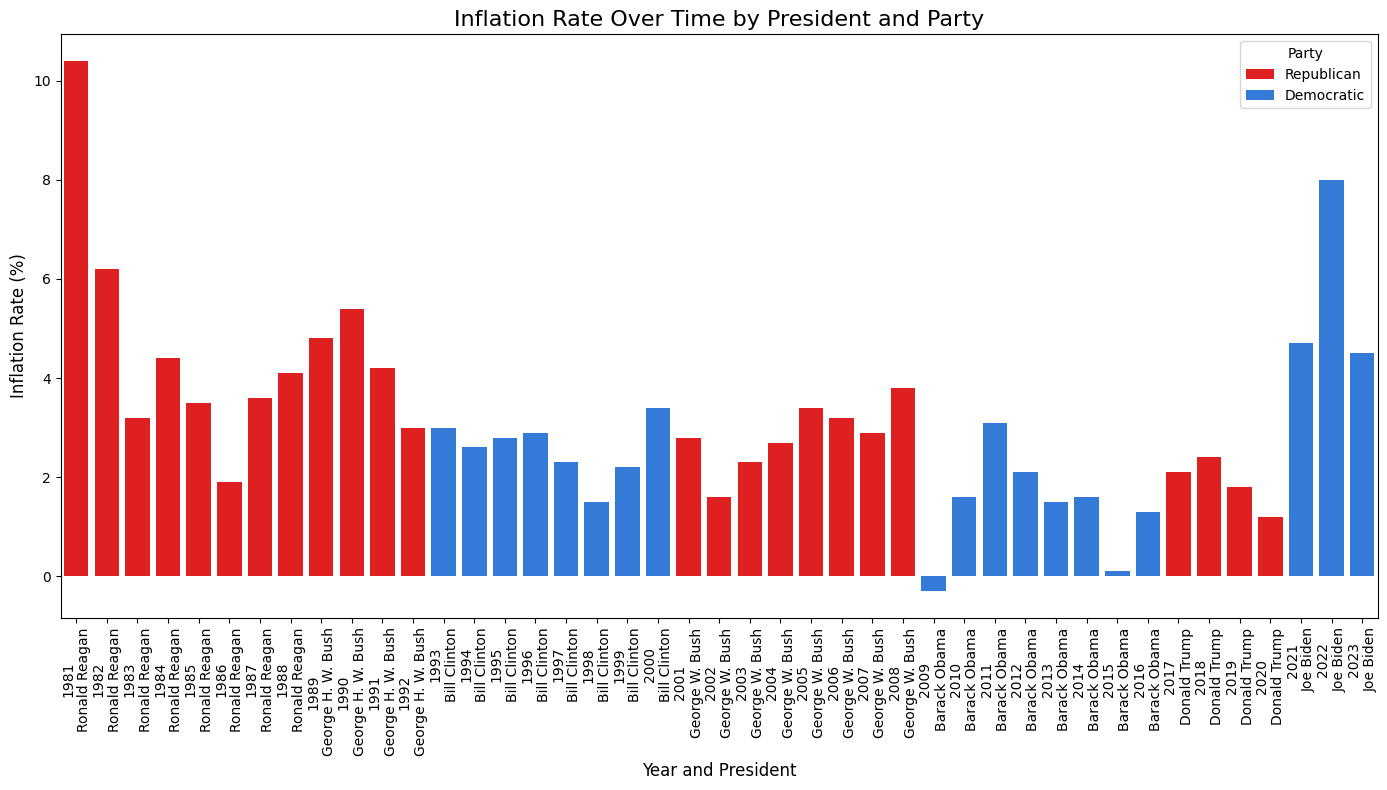

In [52]:
# Plot for Inflation Rate
plt.figure(figsize=(14, 8))
sns.barplot(
    x="year_president",
    y="inflation_rate_percent",
    hue="party",
    data=presidential_performance_df,
    palette=party_colors,
    dodge=False,
)
plt.title("Inflation Rate Over Time by President and Party", fontsize=16)
plt.xlabel("Year and President", fontsize=12)
plt.ylabel("Inflation Rate (%)", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(title="Party")
plt.tight_layout()
plt.show()

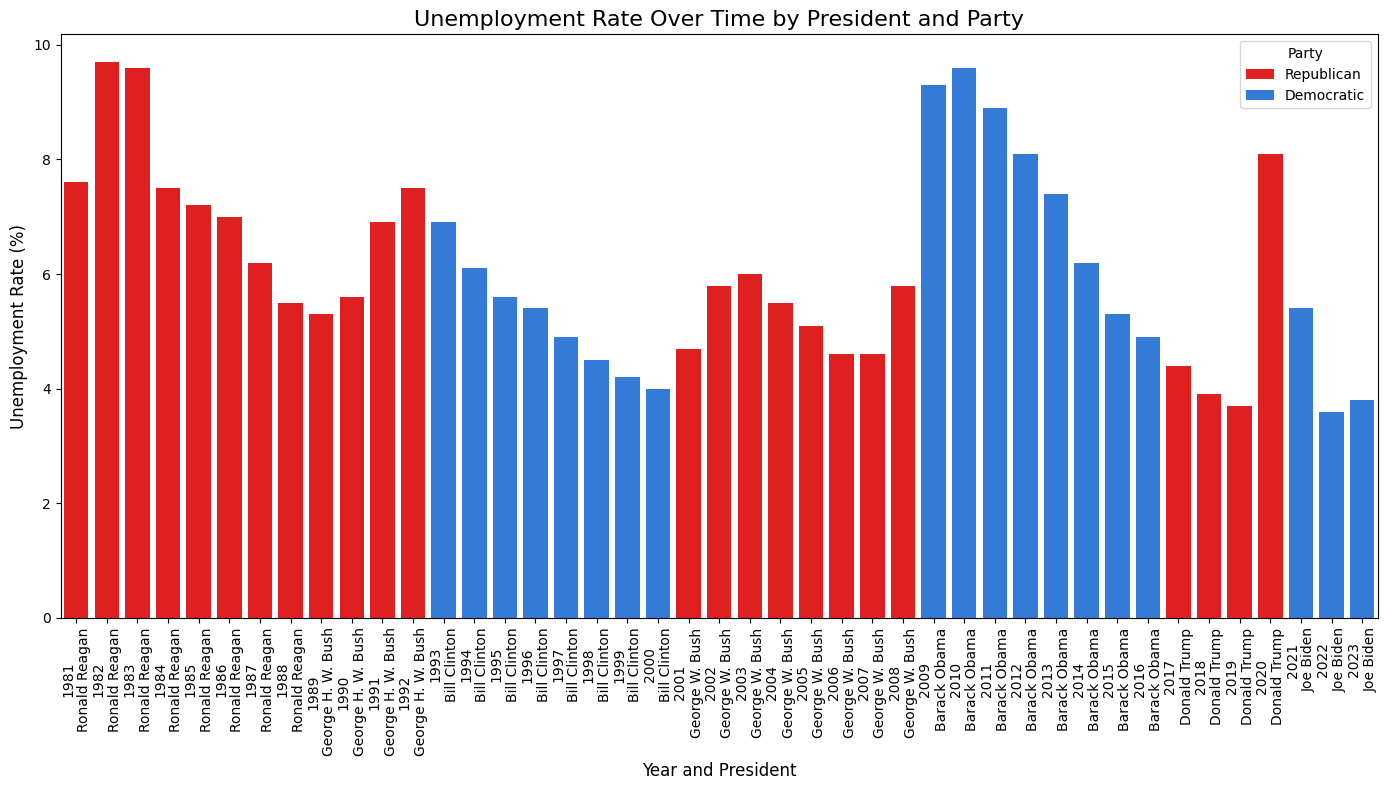

In [53]:
# Plot for Unemployment Rate
plt.figure(figsize=(14, 8))
sns.barplot(
    x="year_president",
    y="unemployment_percent",
    hue="party",
    data=presidential_performance_df,
    palette=party_colors,
    dodge=False,
)
plt.title("Unemployment Rate Over Time by President and Party", fontsize=16)
plt.xlabel("Year and President", fontsize=12)
plt.ylabel("Unemployment Rate (%)", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(title="Party")
plt.tight_layout()
plt.show()

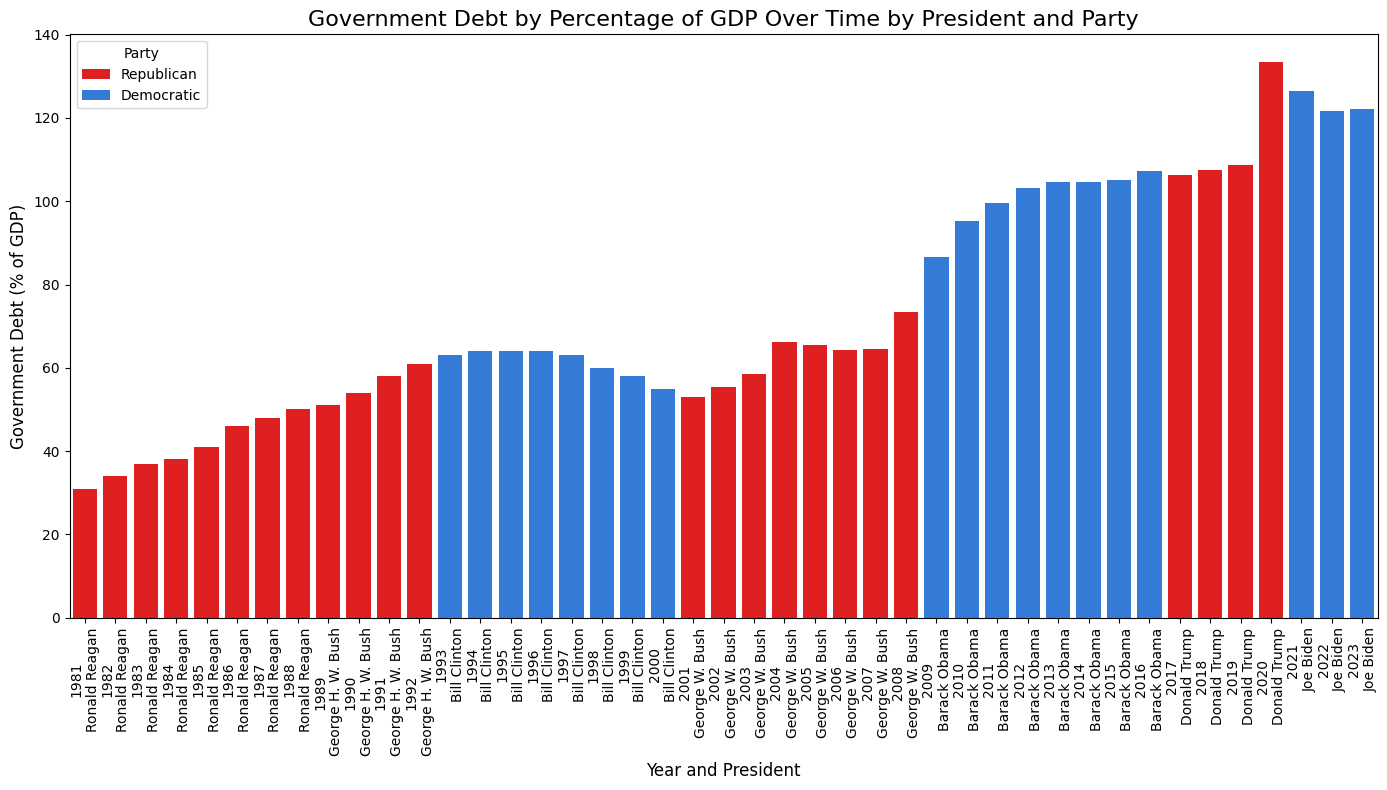

In [54]:
# Plot for Government Debt as Percentage of GDP
plt.figure(figsize=(14, 8))
sns.barplot(
    x="year_president",
    y="government_debt_by_percent_of_gdp",
    hue="party",
    data=presidential_performance_df,
    palette=party_colors,
    dodge=False,
)
plt.title(
    "Government Debt by Percentage of GDP Over Time by President and Party", fontsize=16
)
plt.xlabel("Year and President", fontsize=12)
plt.ylabel("Government Debt (% of GDP)", fontsize=12)
plt.xticks(rotation=90, ha="center")
plt.legend(title="Party")
plt.tight_layout()
plt.show()